In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sklearn
import pickle
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc,classification_report


In [2]:
import warnings
# Suppress all warnings
warnings.filterwarnings("ignore")

In [3]:
df=pd.read_csv("/Users/itobuz/Downloads/product_dataset.csv")

In [4]:
# Define time of day buckets
def time_of_day(hour):
    if hour < 12:
        return 0
    elif hour < 18:
        return 1
    elif hour < 22:
        return 2
    else:
        return 3
df['time_of_day'] = df['order_hour_of_day'].apply(time_of_day)
# Days Since Last Purchase
df['days_since_last_purchase'] = df.groupby(['user_id', 'product_id'])['days_since_prior_order'].shift(-1).fillna(0)
# Number of orders per user
df['user_order_count'] = df.groupby('user_id')['order_id'].transform('count')
# Sum of items ordered per order
df['total_items_ordered'] = df.groupby('order_id')['add_to_cart_order'].transform('sum')
# Total orders for each product
df['product_popularity'] = df.groupby('product_id')['order_id'].transform('count')
# Average order hour for each user
df['avg_order_hour'] = df.groupby('user_id')['order_hour_of_day'].transform('mean')
# Order Frequency
df['order_frequency'] = df.groupby(['user_id', 'product_id'])['order_id'].transform('count')
# Product Affinity by Department
df['department_affinity'] = df.groupby(['user_id', 'department_id'])['order_id'].transform('count') / df.groupby('user_id')['order_id'].transform('count')
# Time of Purchase Features
df['preferred_order_hour'] = df.groupby('user_id')['order_hour_of_day'].transform('mean')
df['preferred_order_dow'] = df.groupby('user_id')['order_dow'].transform('mean')
# Average Reorder Rate
df['avg_reorder_rate'] = df.groupby(['user_id'])['reordered'].transform('mean')
# Product Reorder Frequency (across all users)
df['product_reorder_frequency'] = df.groupby('product_id')['reordered'].transform('sum')
# User's Reorder Rate for Product
df['user_product_reorder_rate'] = df.groupby(['user_id', 'product_id'])['reordered'].transform('mean')
# Order Count for Product by User
df['user_product_order_count'] = df.groupby(['user_id', 'product_id'])['order_id'].transform('count')

Since the product name hs more than 15 classes and I have to fit some classification model so converting it to numerical column would help therefor I have used Target Encoding.

In [5]:

import pandas as pd

# Assuming you have a DataFrame `df` with columns 'aisle', 'product_name', 'department', and 'target'

# Function to perform target encoding
def target_encode(df, columns, target):
    encoded_df = df.copy()
    
    for col in columns:
        # Calculate the mean of target per category
        means = df.groupby(col)[target].mean()
        # Map the means to the respective column in the dataframe
        encoded_df[col] = encoded_df[col].map(means)
    
    return encoded_df

# Columns to encode
columns_to_encode = ['aisle', 'product_name', 'department']
target_column = 'reordered'

# Apply target encoding
encoded_df = target_encode(df, columns_to_encode, target_column)

In [6]:
# Assuming encoded_df contains the target encoded columns
df[columns_to_encode] = encoded_df[columns_to_encode]

In [7]:
df.head(5)

,product_id,product_name,aisle_id,department_id,department,aisle,order_id,add_to_cart_order,reordered,user_id,...,avg_order_hour,order_frequency,department_affinity,preferred_order_dow,avg_reorder_rate,user_product_reorder_rate,time_of_day,preferred_order_hour,product_reorder_frequency,user_product_order_count
0,0.809024,0.601386,61,19,0.573992,0.546284,0.633902,0.062500,0.0,0.133167,...,0.549790,1,0.032258,0.500000,0.419355,0.0,0,0.549790,2604.0,1
1,0.618894,0.464052,7,12,0.566731,0.537474,0.484084,0.013889,0.0,0.905217,...,0.478261,1,0.027027,0.626126,0.459459,0.0,0,0.478261,71.0,1
2,0.894017,0.544089,130,14,0.563145,0.504774,0.845435,0.069444,0.0,0.904781,...,0.557252,1,0.015267,0.614504,0.625954,0.0,0,0.557252,3332.0,1
3,0.857850,0.425676,16,4,0.649794,0.517345,0.607694,0.013889,0.0,0.718440,...,0.717391,1,1.000000,0.500000,0.000000,0.0,0,0.717391,1701.0,1
4,0.537525,0.539916,79,1,0.541962,0.581232,0.185535,0.020833,0.0,0.876023,...,0.673913,1,0.142857,0.511905,0.000000,0.0,0,0.673913,514.0,1


In [8]:
df.shape

(9730347, 28)

**Time of day buckets**
`# Time of day is categorized into 4 buckets: morning, afternoon, evening, and night.`  
`# This helps capture temporal patterns in user behavior. For example, some users may prefer ordering in the morning, while others may prefer evening or night orders.`  
`# It helps in predicting which products a user may be interested in purchasing next.`

---

**Days Since Last Purchase**  
`# This calculates the days since a user last purchased a specific product.`  
`# It is a useful metric for understanding the user's purchase cycle and identifying products that may be due for reordering.`  
`# It helps in predicting which products a user may be interested in purchasing next.`

---

**Number of orders per user**  
`# This feature tracks the total number of orders placed by a user.`  
`# Users who place more orders are more engaged and might have a higher likelihood of purchasing similar items in the future.`  
`# It helps in understanding user activity and engagement, which is key for personalization.`

---

**Sum of items ordered per order**  
`# This calculates the total number of items ordered in each order.`  
`# Orders with more items may indicate bulk buying or more diverse product preferences, which can be useful for recommending related items.`  
`# It helps to infer user preferences and buying habits, which improves recommendations.`

---

**Total orders for each product**  
`# This feature measures the popularity of each product by counting how many times it has been ordered across all users.`  
`# It is important for product recommender systems to give higher priority to popular items, as they tend to be more frequently purchased.`  
`# Popular products are often good candidates for recommendations.`

---

**Average order hour for each user**  
`# This calculates the average hour of the day when a user places orders.`  
`# It helps in identifying time-based purchasing patterns, allowing recommendations to align with the user's preferred order times.`  
`# Users who typically order at certain times may be more likely to buy products recommended during those times.`

---

**Order Frequency**  
`# This tracks how often a user purchases the same product.`  
`# High-frequency orders for a product indicate a strong preference or habit, which is important for identifying repeat purchases and cross-selling opportunities.`  
`# This feature helps in recommending products that a user frequently purchases.`

---

**Product Affinity by Department**  
`# This calculates the proportion of orders within a department for each user.`  
`# It helps to understand a user's affinity for different product departments (e.g., electronics, groceries).`  
`# It enables personalized recommendations based on user’s department preferences, improving the relevance of suggested products.`

---

**Time of Purchase Features: Preferred Hour and Day of Week**  
`# These features capture the user's preferred time of day and day of the week for placing orders.`  
`# Understanding when a user tends to make purchases can help recommend products at the right times, improving the likelihood of conversion.`  
`# It enhances temporal personalization in product recommendations.`

---

**Average Reorder Rate**  
`# This measures the average likelihood of a user reordering items.`  
`# A higher reorder rate indicates that the user is more likely to repurchase items they've ordered in the past.`  
`# This feature is important for recommending products the user may wish to reorder based on their previous behaviors.`

---

**Product Reorder Frequency (across all users)**  
`# This feature calculates how often a product is reordered across all users.`  
`# Products that are frequently reordered are strong candidates for recommendation, as they have a high likelihood of being bought again.`  
`# It helps to surface products that are not only popular but also have a high tendency for repeat purchases.`

---

**User's Reorder Rate for Product**  
`# This feature measures the likelihood that a specific user will reorder a specific product.`  
`# It helps to capture individual user-product interactions, which can be crucial for personalized product recommendations.`  
`# It enhances the ability to predict which products a user is most likely to reorder.`

---

**Order Count for Product by User**  
`# This calculates the number of times a user has ordered a specific product.`  
`# It is helpful for identifying products with high user-specific engagement, which can be used for creating personalized recommendations.`  
`# Products with higher order counts are more likely to be recommended to users who have shown strong interest in them.`

In [9]:
# Step 1: Compute the correlation matrix
correlation_matrix = df.corr()

# Step 2: Set a threshold for high correlation (e.g., > 0.9 or < -0.9)
threshold = 0.9

# Step 3: Find pairs of features that have high correlation
collinear_pairs = []

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            collinear_pairs.append((correlation_matrix.columns[i], correlation_matrix.columns[j]))

# Step 4: Display collinear pairs
if collinear_pairs:
    print("Collinear feature pairs (correlation > {:.2f}):".format(threshold))
    for pair in collinear_pairs:
        print(f"  {pair[0]} and {pair[1]}")
else:
    print("No collinear features found with correlation greater than {:.2f}".format(threshold))

Collinear feature pairs (correlation > 0.90):
  preferred_order_hour and avg_order_hour
  product_reorder_frequency and product_popularity
  user_product_order_count and order_frequency


In [7]:
# List of pairs of correlated columns to drop one from each
columns_to_drop = [
   ('order_hour_of_day', 'time_of_day'),   #Drop one from this pair
   ('product_popularity', 'product_reorder_frequency'),  # Drop one from this pair
   ('avg_order_hour', 'preferred_order_hour'),  # Drop one from this pair
    ('order_frequency', 'user_product_order_count')  # Drop one from this pair
]

# Drop one column from each pair
for col1, col2 in columns_to_drop:
    df = df.drop(columns=[col2])  # Drop the second column in each pair

I have taken one of the columns since they were correlated.

In [9]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the scaler
scaler = MinMaxScaler()

# List the columns to scale
columns_to_scale = [
    'product_id', 'order_id', 'add_to_cart_order', 'reordered', 'user_id',
       'order_number', 'order_dow', 'order_hour_of_day',
       'days_since_prior_order', 'days_since_last_purchase',
       'user_order_count', 'total_items_ordered', 'product_popularity',
       'avg_order_hour', 'order_frequency', 'department_affinity',
        'preferred_order_dow', 'avg_reorder_rate',
        'user_product_reorder_rate','department','product_name','aisle']
# Fit and transform the scaler on the selected columns
df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])

From correlation analysis I found that these columns were having correlation so I have dropped one of them.

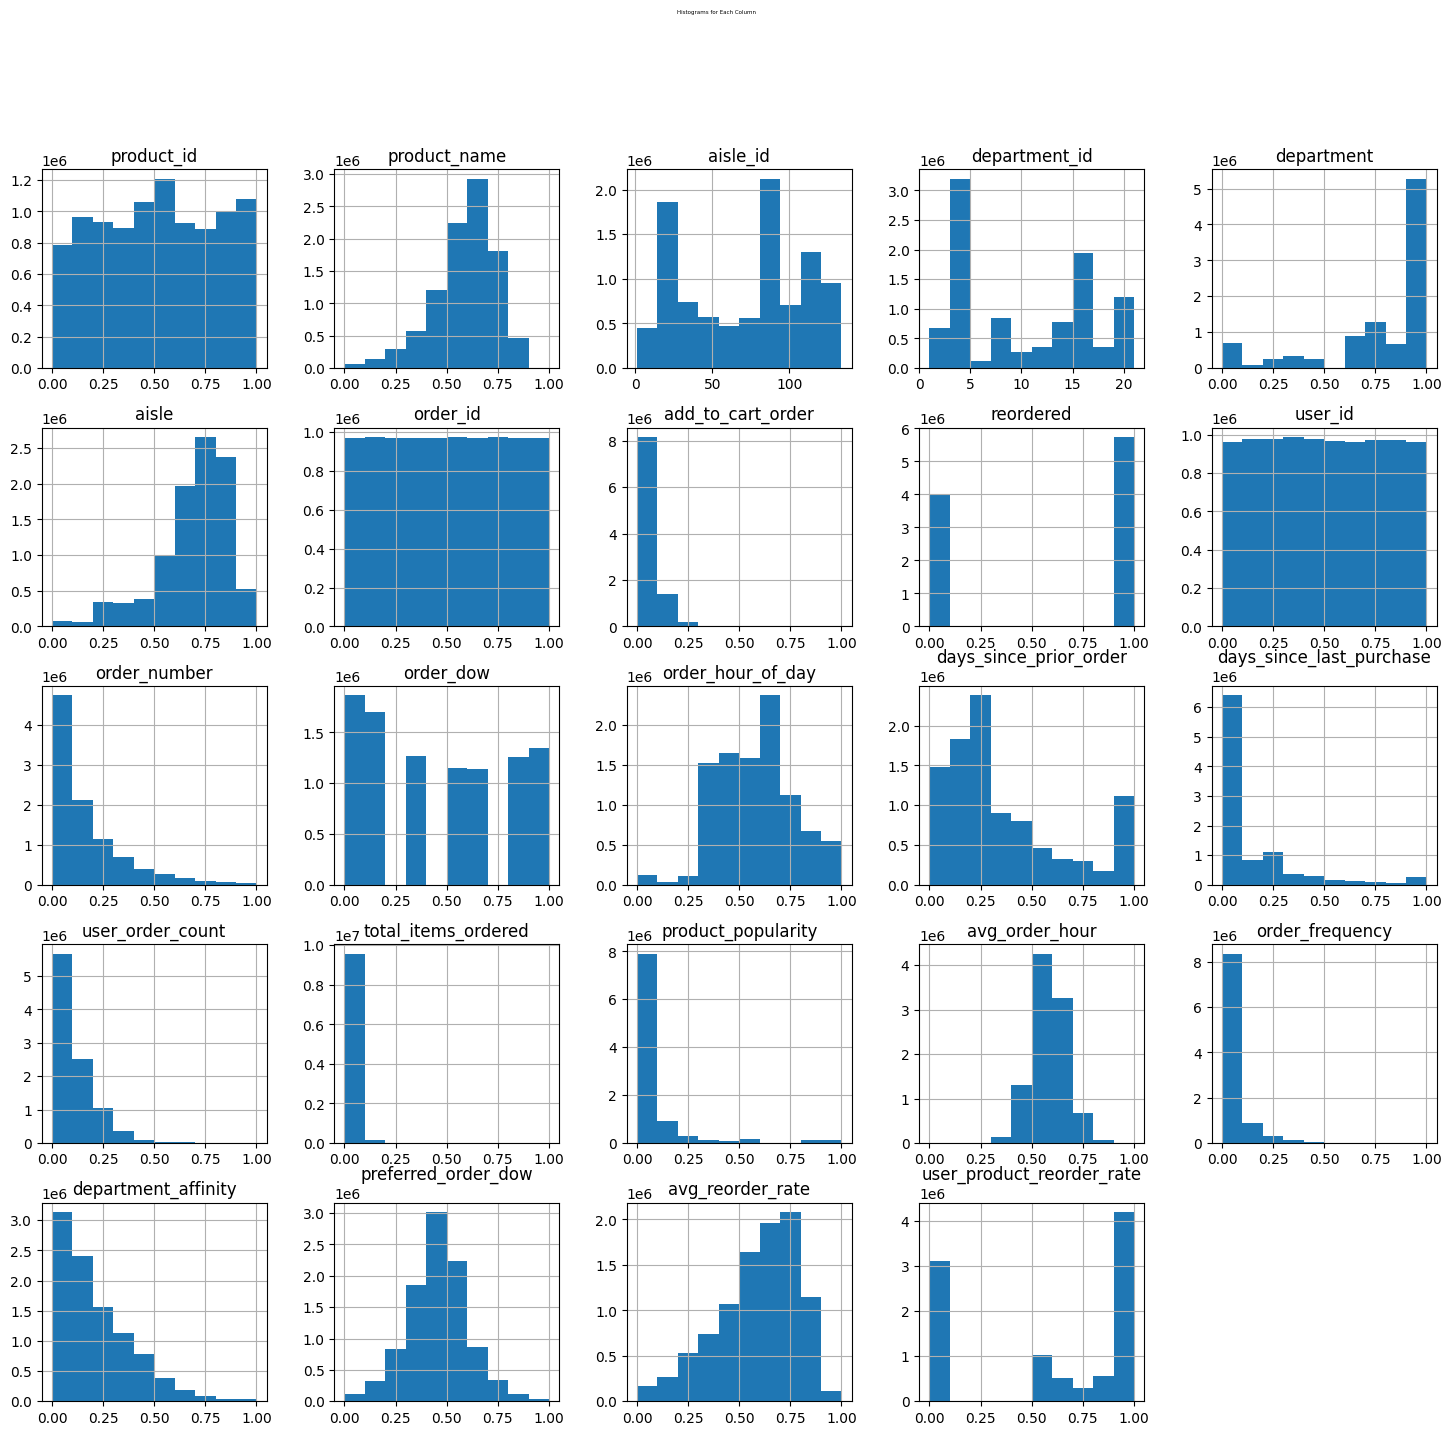

In [12]:
# Set up the plot grid
df.hist(bins=10, figsize=(18, 16), grid=True)

# Display the plot
plt.suptitle('Histograms for Each Column', fontsize=4)
plt.show()

In [5]:

# Assuming df is your DataFrame and 'reordered' is the target variable
X = df.drop(columns=['reordered'])  # Features
y = df['reordered']  # Target variable

In [6]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [9]:
from sklearn.linear_model import LogisticRegression
log_reg= LogisticRegression(max_iter=500, solver='lbfgs')
log_reg.fit(X_train, y_train)

/Users/itobuz/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=500)

In [20]:


# Apply L2 regularization (Ridge)
log_reg_l2 = LogisticRegression(max_iter=500, solver='lbfgs', penalty='l2', C=1.0)
log_reg_l2.fit(X_train, y_train)

# Evaluate the model (example)
accuracy_l2 = log_reg_l2.score(X_test, y_test)
print(f'L2 Regularization (Ridge) Accuracy: {accuracy_l2:.4f}')

L2 Regularization (Ridge) Accuracy: 0.9515


In [21]:
from sklearn.linear_model import LogisticRegression

# Apply L1 regularization (Lasso)
log_reg_l1 = LogisticRegression(max_iter=500, solver='liblinear', penalty='l1', C=1.0)
log_reg_l1.fit(X_train, y_train)

# Evaluate the model (example)
accuracy_l1 = log_reg_l1.score(X_test, y_test)
print(f'L1 Regularization (Lasso) Accuracy: {accuracy_l1:.4f}')

L1 Regularization (Lasso) Accuracy: 0.9521


In [7]:
from sklearn.linear_model import LogisticRegression

# Apply ElasticNet regularization
log_reg_en = LogisticRegression(max_iter=40, solver='saga', penalty='elasticnet', l1_ratio=0.5, C=1.0)
log_reg_en.fit(X_train, y_train)

# Evaluate the model (example)
accuracy_en = log_reg_en.score(X_test, y_test)
print(f'ElasticNet Regularization Accuracy: {accuracy_en:.4f}')

/Users/itobuz/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


ElasticNet Regularization Accuracy: 0.9518


In [15]:
with open('/Users/itobuz/project/DS_Internship_Tasks/product_recommendation_system/models.pkl', 'wb') as f:
    pickle.dump(log_reg, f)

In [16]:
from sklearn.model_selection import train_test_split
# Split X_test and y_test further into test and validation sets (50% each)
X_test_final, X_val, y_test_final, y_val = train_test_split(X_test, y_test, test_size=0.15, random_state=42)
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
# Predict on the test set
y_pred = log_reg.predict(X_test_final)

# Calculate accuracy using accuracy_score
accuracy = accuracy_score(y_test_final, y_pred)
print(f"Model Accuracy: {accuracy:.4f}")

# Alternatively, using the model's score method
accuracy_alternate = log_reg.score(X_test, y_test)
print(f"Model Accuracy (using score method): {accuracy_alternate:.4f}")

# Predict on the final test set
y_test_pred = log_reg.predict(X_test_final)

# Calculate the F1 score
f1 = f1_score(y_test_final, y_test_pred)
print(f"Model Accuracy (using f1-score method): {accuracy_alternate:.4f}")

Model Accuracy: 0.9515
Model Accuracy (using score method): 0.9515
Model Accuracy (using f1-score method): 0.9515


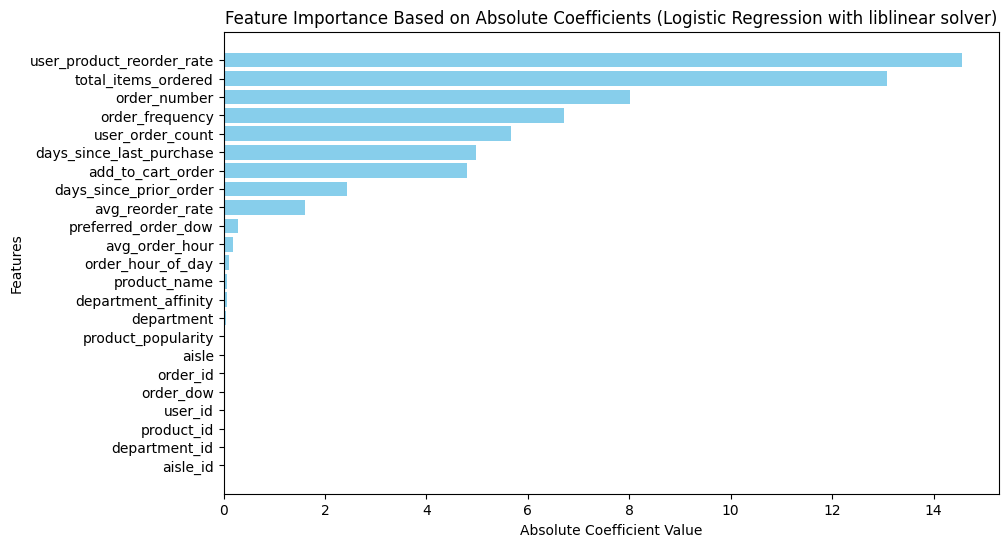

In [19]:
# Step 1: Train Logistic Regression with 'liblinear' solver
log_reg = LogisticRegression(solver='liblinear')
log_reg.fit(X_train, y_train)

# Step 2: Get the absolute value of coefficients (feature importance)
importance = np.abs(log_reg.coef_[0])

# Step 3: Create a DataFrame to store feature names and their corresponding importance
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importance})

# Step 4: Sort the DataFrame by importance in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Step 5: Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Absolute Coefficient Value')
plt.ylabel('Features')
plt.title('Feature Importance Based on Absolute Coefficients (Logistic Regression with liblinear solver)')
plt.gca().invert_yaxis()  # To have the most important feature on top
plt.show()

In [15]:
# Get the feature importances based on the coefficients
coefficients = log_reg.coef_[0]  # Get the coefficients for the model
feature_importances = np.abs(coefficients)  # Use absolute value of coefficients for importance

# Create a DataFrame for better visualization
feature_names = X_train.columns  # Assuming your data is in a DataFrame
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print(importance_df)

                      Feature  Importance
22  user_product_reorder_rate   14.294203
9                order_number    7.854495
18            order_frequency    6.466954
14           user_order_count    4.960673
13   days_since_last_purchase    4.818360
15        total_items_ordered    3.096358
12     days_since_prior_order    2.346053
21           avg_reorder_rate    1.632778
7           add_to_cart_order    1.294107
20        preferred_order_dow    0.217780
17             avg_order_hour    0.184565
11          order_hour_of_day    0.118034
16         product_popularity    0.077651
1                product_name    0.055449
10                  order_dow    0.043285
4                  department    0.039970
8                     user_id    0.028176
5                       aisle    0.025761
19        department_affinity    0.025313
6                    order_id    0.021774
0                  product_id    0.007240
3               department_id    0.004249
2                    aisle_id    0

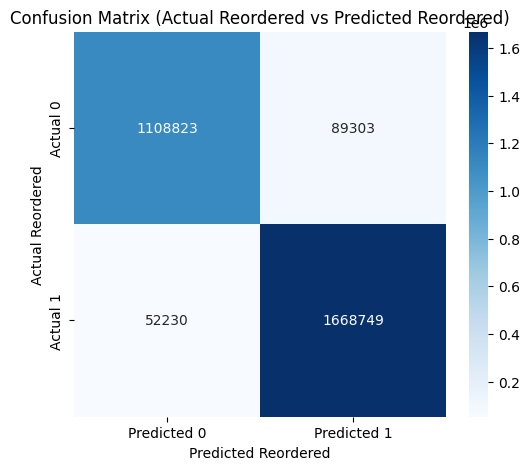

In [18]:

# Predict the classes on the test data
y_pred = log_reg.predict(X_test)
#Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix (Actual Reordered vs Predicted Reordered)')
plt.xlabel('Predicted Reordered')
plt.ylabel('Actual Reordered')
plt.show()

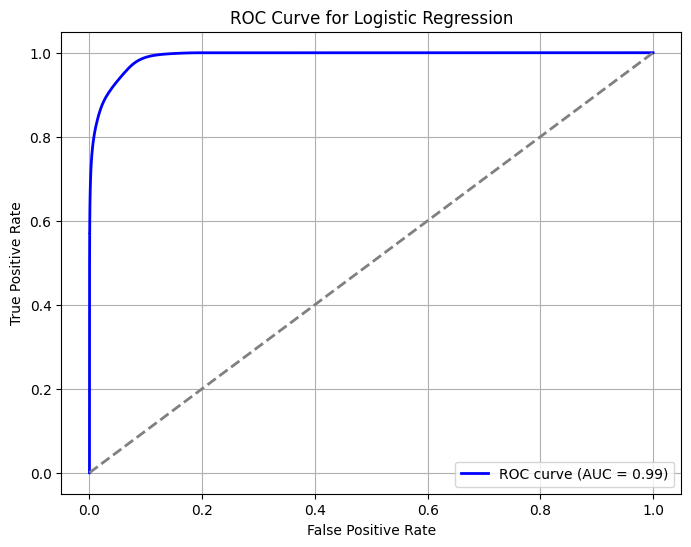

In [12]:
# Predict probabilities for the positive class (class 1)
y_probs = log_reg.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class

# Compute ROC curve and AUC score
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Logistic Regression')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [19]:
# Print the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.93      0.94   1198126
         1.0       0.95      0.97      0.96   1720979

    accuracy                           0.95   2919105
   macro avg       0.95      0.95      0.95   2919105
weighted avg       0.95      0.95      0.95   2919105



In [22]:

#Univariate Statistical Tests (ANOVA F-test)
# Select the top 10 features based on ANOVA F-statistic
selector = SelectKBest(f_classif, k=10)
selector.fit(X, y)
selected_features = X.columns[selector.get_support()]
print(f"Top 10 features based on ANOVA F-test: {selected_features}")

Top 10 features based on ANOVA F-test: Index(['product_name', 'department', 'aisle', 'order_number',
       'days_since_last_purchase', 'user_order_count', 'product_popularity',
       'order_frequency', 'avg_reorder_rate', 'user_product_reorder_rate'],
      dtype='object')


The **ANOVA F-test** was used to identify which features have the most significant impact on the target variable. The top 10 features based on the F-test scores are:

1. **product_name**
2. **department**
3. **aisle**
4. **order_number**
5. **days_since_last_purchase**
6. **user_order_count**
7. **product_popularity**
8. **order_frequency**
9. **avg_reorder_rate**
10. **user_product_reorder_rate**

These features are ranked based on their ability to explain the variance in the target variable. Here are some key insights we can generate from these top features:

---

#### 1. **product_name**
   - **Insight**: The product name appears to be a strong factor influencing the target variable. This suggests that the specific product purchased has a significant relationship with the target, potentially due to brand preferences, product category, or individual product characteristics.

#### 2. **department**
   - **Insight**: The department in which a product belongs (e.g., electronics, clothing, groceries) significantly impacts the target. This could indicate that purchasing behavior differs by department, with certain categories driving more purchases or reorders.

#### 3. **aisle**
   - **Insight**: Aisle information, likely representing product grouping within a store or online catalog, shows high importance. This suggests that products located in specific aisles may be more likely to be purchased or reordered, potentially due to customer preferences or shopping habits.

#### 4. **order_number**
   - **Insight**: The number of orders a user has made (order number) is another strong feature. This may indicate that frequent buyers tend to reorder products more often, or that the number of orders correlates with customer loyalty.

#### 5. **days_since_last_purchase**
   - **Insight**: The time elapsed since a user's last purchase plays an important role. A shorter gap since the last purchase may imply higher likelihood of reorder, especially for products that are replenishable or have shorter usage cycles (e.g., consumables, toiletries).

#### 6. **user_order_count**
   - **Insight**: The total number of orders made by the user over their lifetime seems to significantly influence the target variable. Users with a higher order count are more likely to engage in repeat purchases, which may be tied to customer retention.

#### 7. **product_popularity**
   - **Insight**: Product popularity (possibly based on sales volume or customer ratings) is a strong predictor. Popular products are more likely to be reordered due to higher visibility, brand recognition, or better perceived value.

#### 8. **order_frequency**
   - **Insight**: How often a user places orders is directly linked to repeat purchase behavior. Higher order frequency may suggest a user who is highly engaged, and thus, likely to reorder products regularly.

#### 9. **avg_reorder_rate**
   - **Insight**: The average reorder rate for a user indicates how likely they are to repurchase the same product. A higher reorder rate suggests a strong loyalty or satisfaction with products, which can be a key factor in predicting future behavior.

#### 10. **user_product_reorder_rate**
   - **Insight**: This feature is likely a measure of how often a user reorders specific products. A higher rate of product-specific reorders suggests the user is more loyal to certain products, and understanding this behavior could help in developing targeted retention strategies.

In [23]:
#L1 Regularization (Lasso)** - Feature selection via Lasso
lasso = Lasso(alpha=0.01)  # Lasso regularization
lasso.fit(X, y)
lasso_selected_features = X.columns[lasso.coef_ != 0]
print(f"Selected features using Lasso regularization: {lasso_selected_features}")

Selected features using Lasso regularization: Index(['days_since_last_purchase', 'user_product_reorder_rate'], dtype='object')


Lasso Regularization: Selected Features



#### Key Insights from the Selected Features:

---

#### 1. **days_since_last_purchase**
   - **Insight**: The time since the last purchase is a critical feature in predicting whether a customer will reorder a product. A smaller gap between purchases suggests a higher likelihood of a reorder. This is especially relevant for products that are regularly consumed or replenished, such as groceries, toiletries, or consumables. Customers who make frequent purchases may have higher brand or product loyalty.
   
   - **Possible Business Implications**:
     - **Customer Retention**: By understanding the time intervals between purchases, businesses can identify customers who may be at risk of churn (e.g., long gaps in purchase history) and create targeted marketing campaigns to re-engage them.
     - **Product Restocking or Promotions**: For products with shorter repurchase cycles, businesses can optimize inventory and marketing strategies based on predicted reorder times.

#### 2. **user_product_reorder_rate**
   - **Insight**: This feature indicates how often a specific user reorders a particular product. A higher reorder rate signifies a customer’s strong preference or satisfaction with that product, making it a strong predictor for future reorders. This feature suggests that repeat customers who are satisfied with certain products are more likely to purchase them again.

   - **Possible Business Implications**:
     - **Customer Loyalty and Satisfaction**: A high user product reorder rate could signal strong customer loyalty, which can be leveraged for personalized offers, discounts, or targeted promotions on related products.
     - **Product Recommendations**: Businesses can use this feature to recommend similar products to loyal customers based on their past reorder behavior, increasing the likelihood of cross-selling or upselling.
     - **Customer Segmentation**: Customers with high reorder rates could be segmented as "loyal customers" and treated with special loyalty programs, exclusive offers, or rewards to retain their business.


The **Lasso regularization** method has identified two important features that drive the likelihood of product reordering:

- **Days Since Last Purchase**: Suggests that recent purchasing activity is highly predictive of future reorders.
- **User Product Reorder Rate**: Highlights that customers with a history of frequent product reorders are more likely to continue reordering the same products in the future.

In [ ]:
df.columns

(9730347, 24)

Index(['product_id', 'product_name', 'aisle_id', 'department_id', 'department',
       'aisle', 'order_id', 'add_to_cart_order', 'reordered', 'user_id',
       'order_number', 'order_dow', 'order_hour_of_day',
       'days_since_prior_order', 'days_since_last_purchase',
       'user_order_count', 'total_items_ordered', 'product_popularity',
       'avg_order_hour', 'order_frequency', 'department_affinity',
       'preferred_order_dow', 'avg_reorder_rate', 'user_product_reorder_rate'],
      dtype='object')